In [1]:
import os, sys, cv2
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
# load the .npz file of features
f = np.load(os.getcwd()+"/MusicFeatures.npz")
S = f['spec']
mfcc = f['mfcc']
mel = f['mel']
chroma = f['chroma']
y = f['target']

print(S.shape, mfcc.shape, mel.shape, chroma.shape, y.shape)
# split train-test data
S_train, S_test, mfcc_train, mfcc_test, mel_train, mel_test, chroma_train, chroma_test, y_train, y_test = train_test_split(S, mfcc, mel, chroma, y, test_size= 0.2)

(800, 1025, 1293) (800, 10, 1293) (800, 128, 1293) (800, 12, 1293) (800, 8)


In [3]:
# Spectrogram
# maximum1 = np.amax(S_train)
# S_train = S_train/np.amax(maximum1)
# S_test = S_test/np.amax(maximum1)

# S_train = S_train.astype(np.float32)
# S_test = S_test.astype(np.float32)

# N, row, col = S_train.shape
# S_train = S_train.reshape((N, row, col, 1))

# N, row, col = S_test.shape
# S_test = S_test.reshape((N, row, col, 1))

import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Assuming S_train and S_test are your spectrogram datasets

# Normalize the spectrograms in batches
batch_size = 32

def normalize_in_batches(data):
    max_vals = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        max_val = np.amax(batch)
        max_vals.append(max_val)
        batch = batch / max_val
        data[i:i+batch_size] = batch
    return data, max_vals

# Normalize training data
S_train_normalized, max_vals_train = normalize_in_batches(S_train.copy())

# Normalize test data using max values from training
max_vals_train = np.array(max_vals_train)
S_test_normalized, _ = normalize_in_batches(S_test.copy())

# Apply the normalization factor to test data
S_test_normalized /= max_vals_train.mean()

# Convert NumPy arrays to PyTorch tensors
S_train_tensor = torch.from_numpy(S_train_normalized).unsqueeze(3).permute(0, 3, 1, 2).float()
S_test_tensor = torch.from_numpy(S_test_normalized).unsqueeze(3).permute(0, 3, 1, 2).float()

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
# Create PyTorch datasets
train_dataset = TensorDataset(S_train_tensor)
test_dataset = TensorDataset(S_test_tensor)

# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
# MFCC
newtrain_mfcc = np.empty((mfcc_train.shape[0], 120, 600))
newtest_mfcc = np.empty((mfcc_test.shape[0], 120, 600))

for i in range(mfcc_train.shape[0]) :
    curr = mfcc_train[i]
    curr = cv2.resize(curr, (600, 120))
    newtrain_mfcc[i] = curr

mfcc_train = newtrain_mfcc

for i in range(mfcc_test.shape[0]) :

  curr = mfcc_test[i]
  curr = cv2.resize(curr, (600, 120))
  newtest_mfcc[i] = curr

mfcc_test = newtest_mfcc

mfcc_train = mfcc_train.astype(np.float32)
mfcc_test = mfcc_test.astype(np.float32)

N, row, col = mfcc_train.shape
mfcc_train = mfcc_train.reshape((N, row, col, 1))

N, row, col = mfcc_test.shape
mfcc_test = mfcc_test.reshape((N, row, col, 1))

mean_data = np.mean(mfcc_train)
std_data = np.std(mfcc_train)

mfcc_train = (mfcc_train - mean_data)/ std_data
mfcc_test = (mfcc_test - mean_data)/ std_data

/root/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/root/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/root/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:215: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/root/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:215: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


In [5]:
# Mel-Spectrogram

maximum = np.amax(mel_train)
mel_train = mel_train/np.amax(maximum)
mel_test = mel_test/np.amax(maximum)

mel_train = mel_train.astype(np.float32)
mel_test = mel_test.astype(np.float32)

N, row, col = mel_train.shape
mel_train = mel_train.reshape((N, row, col, 1))

N, row, col = mel_test.shape
mel_test = mel_test.reshape((N, row, col, 1))

In [6]:
# Save Spectrogram train-test
# np.savez_compressed(os.getcwd()+"/new_spectrogram_train_test.npz", S_train= S_train, S_test= S_test, y_train = y_train, y_test= y_test)
# print('spectrogram_set saved')

# # Save MFCC train-test
# np.savez_compressed(os.getcwd()+"/new_mfcc_train_test.npz", mfcc_train= mfcc_train, mfcc_test= mfcc_test, y_train = y_train, y_test= y_test)
# print('mfcc_set saved')

# # Save Mel-Spectrogram train-test
# np.savez_compressed(os.getcwd()+"/new_mel_train_test.npz", mel_train= mel_train, mel_test= mel_test, y_train = y_train, y_test= y_test)
# print('mel_set saved')


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Load Spectrogram Train-test data
spec_file = np.load(os.getcwd() + "/new_spectrogram_train_test.npz")

def create_data_loader(data, labels, batch_size):
    tensor_data = torch.from_numpy(data).unsqueeze(1).float()
    tensor_labels = torch.from_numpy(labels).float()
    dataset = TensorDataset(tensor_data, tensor_labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
import tqdm as tqdm


batch_size = 100
# Model 1 for Spectrogram

chunk_size = 1000  # Define the chunk size
dim1_length = 800
# Load and process the data in smaller chunks
num_samples_train = dim1_length
num_samples_test = dim1_length

# Convert data to PyTorch tensors
# S_train_tensor = torch.from_numpy(S_train).unsqueeze(1).float()
# S_test_tensor = torch.from_numpy(S_test).unsqueeze(1).float()
# y_train_tensor = torch.from_numpy(y_train).long()
# y_test_tensor = torch.from_numpy(y_test).long()


# Define the CNN model in PyTorch
class SpectrogramCNN(nn.Module):
    def __init__(self):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 8)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.pool(nn.functional.relu(self.conv4(x)))
        x = self.pool(nn.functional.relu(self.conv5(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.softmax(self.fc3(x), dim=1)
        return x

# Create model instance
model = SpectrogramCNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Assuming S_train and y_train are PyTorch tensors
train_dataset = TensorDataset(S_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop in a streaming-like manner
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Iterate through the entire dataset in smaller chunks
    for idx in tqdm.tqdm(range(0, dim1_length, batch_size)):
        S_train_chunk = spec_file['S_train'][idx:idx + batch_size]
        y_train_chunk = spec_file['y_train'][idx:idx + batch_size]

        # move to gpu
        S_train_chunk = torch.from_numpy(S_train_chunk).unsqueeze(1).float().to(device)
        y_train_chunk = torch.from_numpy(y_train_chunk).float().to(device)

        tensor_data = S_train_chunk
        tensor_labels = y_train_chunk
        # dataset = TensorDataset(tensor_data, tensor_labels)
        # train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)       

        # Training loop for each chunk
        # for i, data in enumerate(train_loader, 0):
        #     inputs, labels = data
        #     optimizer.zero_grad()
        #     try:
        #         outputs = model(inputs)
        #     except RuntimeError as exception:
        #         if "out of memory" in str(exception):
        #             print('WARNING: out of memory')
        #             if hasattr(torch.cuda, 'empty_cache'):
        #                 torch.cuda.empty_cache()
        #             else:
        #                 raise exception
        #     loss = criterion(outputs, labels)
        #     loss.backward()
        #     optimizer.step()
            
        #     running_loss += loss.item()
        #     if i % 100 == 99:
        #         print(f'Epoch [{epoch + 1}, {i + 1}], Loss: {running_loss / 100:.3f}')
        #         running_loss = 0.0
        optimizer.zero_grad()
        outputs = model(S_train_chunk)
        loss = criterion(outputs, y_train_chunk)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch [{epoch + 1}, {i + 1}], Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

# Save the model
torch.save(model.state_dict(), './models/new_spec_model_spectrogram1.pth')


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [01:58<00:00, 14.86s/it]


RuntimeError: Parent directory ./models/models does not exist.

In [20]:

torch.save(model.state_dict(), './models/new_spec_model_spectrogram1.pth')


Train Accuracy: 22.34%
Test Accuracy: 15.00%


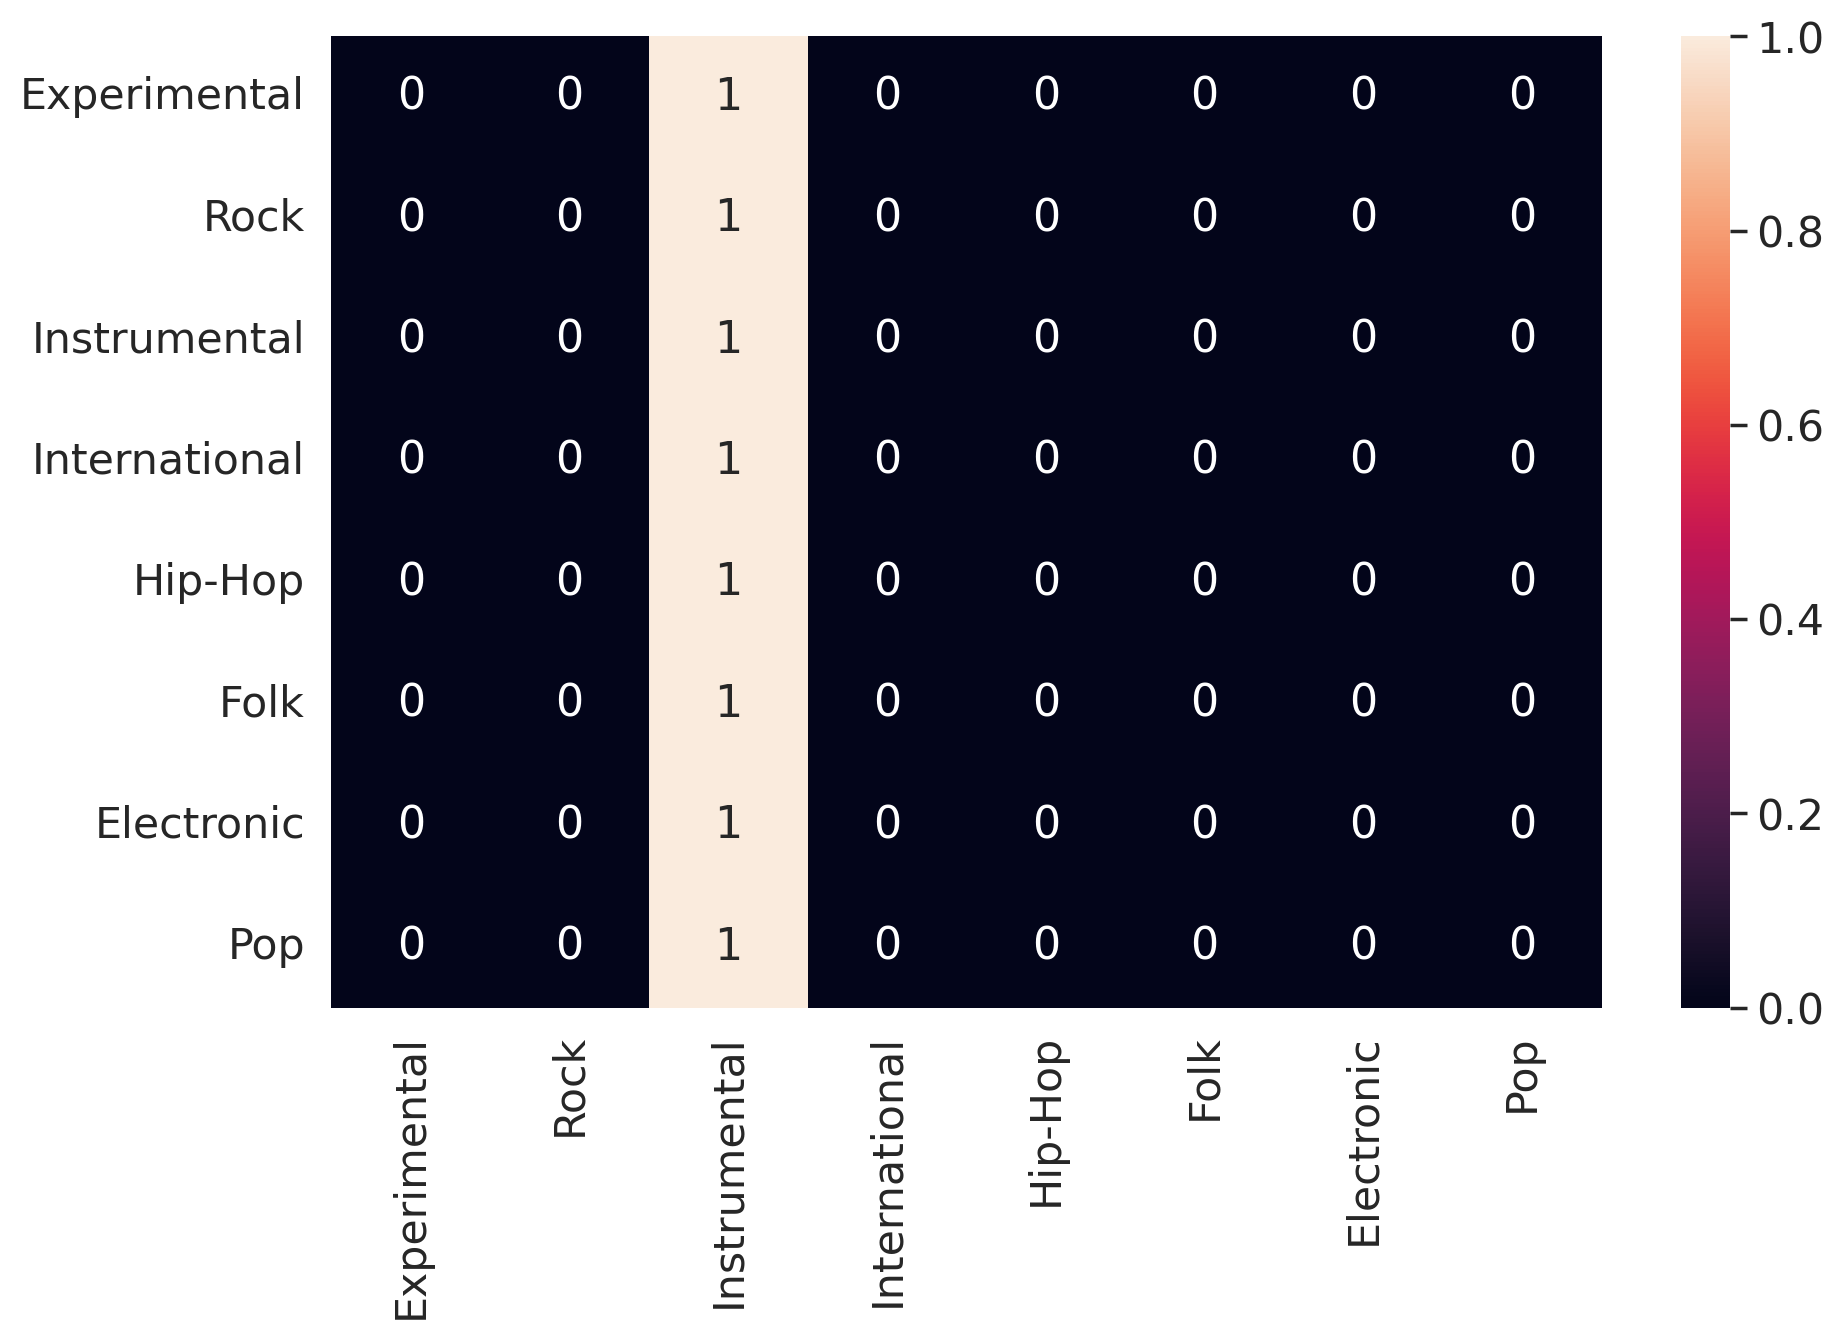

In [17]:
import torch
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Assuming S_train, y_train, S_test, y_test are PyTorch tensors

# Load the saved PyTorch model
model = SpectrogramCNN()
model.load_state_dict(torch.load('./models/new_spec_model_spectrogram1.pth'))

model.eval()

# Function to calculate accuracy
def calculate_accuracy(predictions, targets):
    _, predicted = torch.max(predictions, 1)
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    accuracy = correct / total
    return accuracy * 100

# Function to convert PyTorch tensor to numpy array
def to_numpy(tensor):
    return tensor.detach().cpu().numpy()

# Evaluate on training set
with torch.no_grad():
    train_outputs = model(S_train_tensor)
    train_accuracy = calculate_accuracy(train_outputs, torch.argmax(y_train_tensor, dim=1))

print(f"Train Accuracy: {train_accuracy:.2f}%")

# Evaluate on testing set
with torch.no_grad():
    test_outputs = model(S_test_tensor)
    test_accuracy = calculate_accuracy(test_outputs, torch.argmax(y_test_tensor, dim=1))

print(f"Test Accuracy: {test_accuracy:.2f}%")

# Create a confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    conf_mat = confusion_matrix(y_true, y_pred, normalize='true')
    conf_mat = np.round(conf_mat, 2)

    conf_mat_df = pd.DataFrame(conf_mat, columns=class_names, index=class_names)

    plt.figure(figsize=(10, 7), dpi=200)
    sn.set(font_scale=1.4)
    sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16})  # font size
    plt.tight_layout()
    plt.savefig(os.getcwd() + "/new_spec_conf_mat1.png")

# Convert predictions and labels to numpy arrays
y_true_numpy = to_numpy(torch.argmax(y_test_tensor, dim=1))
y_pred_numpy = to_numpy(torch.argmax(test_outputs, dim=1))

# Plot the confusion matrix
class_names = ['Experimental', 'Rock', 'Instrumental', 'International', 'Hip-Hop', 'Folk', 'Electronic', 'Pop']
plot_confusion_matrix(y_true_numpy, y_pred_numpy, class_names)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming you've loaded your data into S_train, S_test, y_train, y_test

# Convert NumPy arrays to PyTorch tensors
S_train_tensor = torch.tensor(S_train, dtype=torch.float32)
S_test_tensor = torch.tensor(S_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define the model in PyTorch
class SpectrogramModel(nn.Module):
    def __init__(self):
        super(SpectrogramModel, self).__init__()
        # Define layers similar to Keras model

    def forward(self, x):
        # Implement forward pass
        return x

model = SpectrogramModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define PyTorch datasets and dataloaders
train_dataset = TensorDataset(S_train_tensor, y_train_tensor)
test_dataset = TensorDataset(S_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix and visualization
# Please note that the PyTorch confusion matrix and visualization require additional steps beyond this outline.
# You can utilize sklearn's confusion_matrix and seaborn's heatmap similarly to the Keras code for this task.


## MFCC

In [ ]:
history


import os, sys, cv2
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import os, sys, cv2
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import os, sys, cv2

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confu